In [52]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Embedding, Bidirectional, Activation, Dense, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import csv
import codecs

In [13]:
def verbatim_to_char_seq(name, char_indices, maxLen):
    name_chars = list(name)
    name_chars_indices = list(map(lambda char: char_indices[char], name_chars))
    return sequence.pad_sequences([name_chars_indices], maxLen, padding="post", truncating="post")[0]

In [14]:
#import verbatims, put into two lists
verbatims = []
allowedChars = []
with codecs.open('Data/Catagorization training data.csv', 'r', encoding='ascii', errors='ignore') as f:
    reader = csv.reader(f)
    for line in reader:
        temp = line[1].replace('\n', ' ').replace('\r', ' ').replace('<', ' ').replace('>', ' ').replace('*', ' ')
        temp = temp.replace('%', ' ').replace('&', ' ').replace('#', ' ').replace('~', ' ').replace('@', ' ')
        temp = temp.replace('=', ' ').replace('`', ' ').replace(';', ' ').replace('_', ' ').replace('+', ' ')
        temp = (temp[:198] + '..') if len(temp) > 200 else temp
        verbatims.append(temp)

In [15]:
char_list = list(set(''.join(verbatims)))
char_indices = dict((c, i) for i, c in enumerate(char_list))
indices_char = dict((i, c) for i, c in enumerate(char_list))

In [16]:
# get rid of duplicates
verbatims = list(set(verbatims))

In [17]:
#determine the maximum length of the verbatims
maxLen = 0
for v in verbatims:
    if len(v) > maxLen:
        maxLen = len(v)
print(maxLen)

#if the max length is < 50, pad verbatim
#if maxLen < 50:
#    maxLen = 50

200


In [18]:
#create actual dataset to be fed into keras model
X = []

for n in verbatims:
    X.append(verbatim_to_char_seq(n, char_indices, maxLen))
    
X = np.array(X).astype(np.uint8)

print(X.shape)

(118479, 200)


In [19]:
import pickle
pickle.dump((char_list, char_indices, indices_char, X), open('char_autoenc.pkl','wb'))

In [3]:
import pickle
char_list, char_indices, indices_char, X = pickle.load(open( 'char_autoenc.pkl', "rb" ) )

In [20]:
print('Vectorization...')
maxLen = X.shape[1]
import numpy as np

Z = np.zeros((len(X), maxLen, len(char_list)), dtype=np.bool)
for i, seq in enumerate(X):
    for t, word in enumerate(seq[:-1]):
        Z[i, t, word] = 1
        
print(Z[0])

Vectorization...
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [ True False False ..., False False False]
 [ True False False ..., False False False]
 [False False False ..., False False False]]


In [ ]:
import keras.backend as K
#create keras model
batch_size = 256
nb_epoch = 200

latent_dim_out = 128
latent_dim_in = 64

timesteps = maxLen
inputs = Input(shape=(maxLen, len(char_list)))
print("inputs", K.int_shape(inputs) )

#(number of samples, number of timesteps, number of features)
encoded1 = LSTM(latent_dim_out, return_sequences=True)(inputs)
print("encoded1", K.int_shape(encoded1))

encoded2 = LSTM(latent_dim_in)(encoded1)
print("encoded2", K.int_shape(encoded2))

decoded = RepeatVector(timesteps)(encoded2)
print("decoded1", K.int_shape(decoded))

decoded = LSTM(latent_dim_in, return_sequences=True)(decoded)
print("decoded2", K.int_shape(decoded))

decoded = LSTM(latent_dim_out, return_sequences=True)(decoded)
print("decoded3", K.int_shape(decoded))

decoded = Dropout(0.5)(decoded)
decoded = TimeDistributed(Dense(len(char_list)), input_shape=(200, 128))(decoded)
print("output", K.int_shape(decoded))
# is sigmoid the best choice?
activation = Activation('sigmoid')(decoded)

sequence_autoencoder = Model(inputs, activation)
encoder = Model(inputs, encoded2)

#optimizer = Adam(lr = 0.005)
#optimizer = RMSprop(lr=0.01)
sequence_autoencoder.compile(loss='categorical_crossentropy', optimizer='adam')

early_stopping = EarlyStopping(patience=5, verbose=1)
#checkpointer = ModelCheckpoint(filepath='char_lstm2_keras_weights.hdf5', verbose=1, save_best_only=True)
#model2.load_weights('char_lstm2_keras_weights.hdf5')


inputs (None, 200, 48)
encoded1 (None, 200, 128)
encoded2 (None, 64)
decoded1 (None, 200, 64)
decoded2 (None, 200, 64)
decoded3 (None, 200, 128)
output (None, 200, 48)


In [ ]:
#train model on test data
sequence_autoencoder.fit(Z, Z, 
          batch_size=batch_size, 
          epochs=nb_epoch,
          verbose=1,
          shuffle=True,
          validation_split=0.1)

Train on 106631 samples, validate on 11848 samples
Epoch 1/200
 17152/106631 [===>..........................] - ETA: 470s - loss: 2.0720

In [ ]:
sequence_autoencoder.save("seq2seq_model.h5")
#from keras.models import load_model
#sequence_autoencoder = load_model("seq2seq_model.h5")

In [89]:
batch_size = 50
nb_epoch = 2000

latent_dim_out = 128
latent_dim_in = 64

timesteps = maxLen
inputs = Input(shape=(maxLen, len(char_list)))
print("inputs", K.int_shape(inputs) )

decoded = LSTM(latent_dim_in, return_sequences=True)(inputs)
print("output", K.int_shape(decoded))
decoded = Dropout(0.5)(decoded)
decoded = TimeDistributed(Dense(len(char_list)), input_shape=(200, 48))(decoded)

# is sigmoid the best choice?
activation = Activation('sigmoid')(decoded)

sequence_test = Model(inputs, activation)
#encoder = Model(inputs, encoded2)

#optimizer = Adam(lr = 0.005)
#optimizer = RMSprop(lr=0.01)
sequence_test.compile(loss='categorical_crossentropy', optimizer='adadelta')

inputs (None, 200, 48)
output (None, 200, 64)


In [90]:
#train model on test data
sequence_test.fit(Z[:50,:,:], Z[:50,:,:], 
          batch_size=batch_size, 
          epochs=nb_epoch,
          verbose=1,
          shuffle=True,
          validation_split=0.1)

Train on 45 samples, validate on 5 samples
Epoch 1/2000
45/45 [==============================] - 1s - loss: 3.8663 - val_loss: 3.8571
Epoch 2/2000
45/45 [==============================] - 0s - loss: 3.8589 - val_loss: 3.8498
Epoch 3/2000
45/45 [==============================] - 0s - loss: 3.8505 - val_loss: 3.8424
Epoch 4/2000
45/45 [==============================] - 0s - loss: 3.8427 - val_loss: 3.8350
Epoch 5/2000
45/45 [==============================] - 0s - loss: 3.8338 - val_loss: 3.8275
Epoch 6/2000
45/45 [==============================] - 0s - loss: 3.8265 - val_loss: 3.8197
Epoch 7/2000
45/45 [==============================] - 0s - loss: 3.8181 - val_loss: 3.8116
Epoch 8/2000
45/45 [==============================] - 0s - loss: 3.8091 - val_loss: 3.8031
Epoch 9/2000
45/45 [==============================] - 0s - loss: 3.8002 - val_loss: 3.7940
Epoch 10/2000
45/45 [==============================] - 0s - loss: 3.7907 - val_loss: 3.7841
Epoch 11/2000
45/45 [=========================

45/45 [==============================] - 0s - loss: 0.9594 - val_loss: 1.1581
Epoch 90/2000
45/45 [==============================] - 0s - loss: 0.9560 - val_loss: 1.1152
Epoch 91/2000
45/45 [==============================] - 0s - loss: 0.9723 - val_loss: 1.2118
Epoch 92/2000
45/45 [==============================] - 0s - loss: 0.9784 - val_loss: 1.1075
Epoch 93/2000
45/45 [==============================] - 0s - loss: 0.9633 - val_loss: 1.2094
Epoch 94/2000
45/45 [==============================] - 0s - loss: 0.9673 - val_loss: 1.0841
Epoch 95/2000
45/45 [==============================] - 0s - loss: 0.9403 - val_loss: 1.1094
Epoch 96/2000
45/45 [==============================] - 0s - loss: 0.9256 - val_loss: 1.0825
Epoch 97/2000
45/45 [==============================] - 0s - loss: 0.9331 - val_loss: 1.1313
Epoch 98/2000
45/45 [==============================] - 0s - loss: 0.9274 - val_loss: 1.4347
Epoch 99/2000
45/45 [==============================] - 0s - loss: 1.3588 - val_loss: 1.3610
Ep

45/45 [==============================] - 0s - loss: 0.7777 - val_loss: 0.9374
Epoch 178/2000
45/45 [==============================] - 0s - loss: 0.7847 - val_loss: 0.9439
Epoch 179/2000
45/45 [==============================] - 0s - loss: 0.7829 - val_loss: 0.9370
Epoch 180/2000
45/45 [==============================] - 0s - loss: 0.7843 - val_loss: 0.9389
Epoch 181/2000
45/45 [==============================] - 0s - loss: 0.7767 - val_loss: 0.9320
Epoch 182/2000
45/45 [==============================] - 0s - loss: 0.7790 - val_loss: 0.9372
Epoch 183/2000
45/45 [==============================] - 0s - loss: 0.7744 - val_loss: 0.9303
Epoch 184/2000
45/45 [==============================] - 0s - loss: 0.7755 - val_loss: 0.9369
Epoch 185/2000
45/45 [==============================] - 0s - loss: 0.7763 - val_loss: 0.9296
Epoch 186/2000
45/45 [==============================] - 0s - loss: 0.7766 - val_loss: 0.9373
Epoch 187/2000
45/45 [==============================] - 0s - loss: 0.7773 - val_loss:

45/45 [==============================] - 0s - loss: 0.7246 - val_loss: 0.8760
Epoch 266/2000
45/45 [==============================] - 0s - loss: 0.7256 - val_loss: 0.9151
Epoch 267/2000
45/45 [==============================] - 0s - loss: 0.7256 - val_loss: 0.8893
Epoch 268/2000
45/45 [==============================] - 0s - loss: 0.7390 - val_loss: 0.8756
Epoch 269/2000
45/45 [==============================] - 0s - loss: 0.7217 - val_loss: 0.8785
Epoch 270/2000
45/45 [==============================] - 0s - loss: 0.7207 - val_loss: 0.8763
Epoch 271/2000
45/45 [==============================] - 0s - loss: 0.7201 - val_loss: 0.8766
Epoch 272/2000
45/45 [==============================] - 0s - loss: 0.7190 - val_loss: 0.8744
Epoch 273/2000
45/45 [==============================] - 0s - loss: 0.7193 - val_loss: 0.8804
Epoch 274/2000
45/45 [==============================] - 0s - loss: 0.7195 - val_loss: 0.8720
Epoch 275/2000
45/45 [==============================] - 0s - loss: 0.7197 - val_loss:

45/45 [==============================] - 0s - loss: 0.6899 - val_loss: 0.8502
Epoch 354/2000
45/45 [==============================] - 0s - loss: 0.6880 - val_loss: 0.8435
Epoch 355/2000
45/45 [==============================] - 0s - loss: 0.6894 - val_loss: 0.8641
Epoch 356/2000
45/45 [==============================] - 0s - loss: 0.6860 - val_loss: 0.8398
Epoch 357/2000
45/45 [==============================] - 0s - loss: 0.6881 - val_loss: 0.8611
Epoch 358/2000
45/45 [==============================] - 0s - loss: 0.6884 - val_loss: 0.8398
Epoch 359/2000
45/45 [==============================] - 0s - loss: 0.6874 - val_loss: 0.8597
Epoch 360/2000
45/45 [==============================] - 0s - loss: 0.6834 - val_loss: 0.8398
Epoch 361/2000
45/45 [==============================] - 0s - loss: 0.6844 - val_loss: 0.8667
Epoch 362/2000
45/45 [==============================] - 0s - loss: 0.6849 - val_loss: 0.8374
Epoch 363/2000
45/45 [==============================] - 0s - loss: 0.6857 - val_loss:

45/45 [==============================] - 0s - loss: 0.6583 - val_loss: 0.8033
Epoch 442/2000
45/45 [==============================] - 0s - loss: 0.6604 - val_loss: 0.8157
Epoch 443/2000
45/45 [==============================] - 0s - loss: 0.6573 - val_loss: 0.8076
Epoch 444/2000
45/45 [==============================] - 0s - loss: 0.6564 - val_loss: 0.8135
Epoch 445/2000
45/45 [==============================] - 0s - loss: 0.6533 - val_loss: 0.8069
Epoch 446/2000
45/45 [==============================] - 0s - loss: 0.6537 - val_loss: 0.8185
Epoch 447/2000
45/45 [==============================] - 0s - loss: 0.6543 - val_loss: 0.8016
Epoch 448/2000
45/45 [==============================] - 0s - loss: 0.6546 - val_loss: 0.8232
Epoch 449/2000
45/45 [==============================] - 0s - loss: 0.6563 - val_loss: 0.7992
Epoch 450/2000
45/45 [==============================] - 0s - loss: 0.6571 - val_loss: 0.8177
Epoch 451/2000
45/45 [==============================] - 0s - loss: 0.6508 - val_loss:

45/45 [==============================] - 0s - loss: 0.6208 - val_loss: 0.7532
Epoch 530/2000
45/45 [==============================] - 0s - loss: 0.6167 - val_loss: 0.7454
Epoch 531/2000
45/45 [==============================] - 0s - loss: 0.6196 - val_loss: 0.7513
Epoch 532/2000
45/45 [==============================] - 0s - loss: 0.6191 - val_loss: 0.7439
Epoch 533/2000
45/45 [==============================] - 0s - loss: 0.6173 - val_loss: 0.7499
Epoch 534/2000
45/45 [==============================] - 0s - loss: 0.6174 - val_loss: 0.7425
Epoch 535/2000
45/45 [==============================] - 0s - loss: 0.6146 - val_loss: 0.7469
Epoch 536/2000
45/45 [==============================] - 0s - loss: 0.6161 - val_loss: 0.7404
Epoch 537/2000
45/45 [==============================] - 0s - loss: 0.6161 - val_loss: 0.7422
Epoch 538/2000
45/45 [==============================] - 0s - loss: 0.6137 - val_loss: 0.7389
Epoch 539/2000
45/45 [==============================] - 0s - loss: 0.6116 - val_loss:

45/45 [==============================] - 0s - loss: 0.5501 - val_loss: 0.6461
Epoch 618/2000
45/45 [==============================] - 0s - loss: 0.5511 - val_loss: 0.6438
Epoch 619/2000
45/45 [==============================] - 0s - loss: 0.5453 - val_loss: 0.6434
Epoch 620/2000
45/45 [==============================] - 0s - loss: 0.5456 - val_loss: 0.6408
Epoch 621/2000
45/45 [==============================] - 0s - loss: 0.5442 - val_loss: 0.6392
Epoch 622/2000
45/45 [==============================] - 0s - loss: 0.5412 - val_loss: 0.6372
Epoch 623/2000
45/45 [==============================] - 0s - loss: 0.5457 - val_loss: 0.6369
Epoch 624/2000
45/45 [==============================] - 0s - loss: 0.5425 - val_loss: 0.6350
Epoch 625/2000
45/45 [==============================] - 0s - loss: 0.5386 - val_loss: 0.6351
Epoch 626/2000
45/45 [==============================] - 0s - loss: 0.5432 - val_loss: 0.6329
Epoch 627/2000
45/45 [==============================] - 0s - loss: 0.5433 - val_loss:

KeyboardInterrupt: 

In [82]:
Z[:50,:,:].shape

(50, 200, 48)

In [91]:
preds = sequence_test.predict(Z[:5,:,:], batch_size=64, verbose=0)

In [92]:
preds[0]

array([[  3.98337483e-01,   4.90137100e-01,   3.45884711e-01, ...,
          4.08656895e-01,   3.80940765e-01,   3.29707295e-01],
       [  3.45881760e-01,   3.83731902e-01,   1.94581002e-01, ...,
          2.80710995e-01,   2.56413698e-01,   1.79367974e-01],
       [  2.25228444e-01,   2.98587948e-01,   8.03020746e-02, ...,
          1.83218688e-01,   1.38501197e-01,   6.63820133e-02],
       ..., 
       [  9.15932775e-01,   3.00267748e-05,   5.22308846e-06, ...,
          1.65851761e-05,   1.80058287e-05,   3.69853092e-06],
       [  9.15932894e-01,   3.00267438e-05,   5.22307846e-06, ...,
          1.65851761e-05,   1.80058105e-05,   3.69853092e-06],
       [  9.10682678e-01,   3.26108966e-05,   5.41521194e-06, ...,
          1.72657037e-05,   1.88223567e-05,   3.84939995e-06]], dtype=float32)

In [93]:
Z[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [94]:
a=(preds[0]*Z[0])
s=0
for i in a:
    s += i.max()
s

110.64494971827662

In [95]:
s/200

0.55322474859138315

Training history


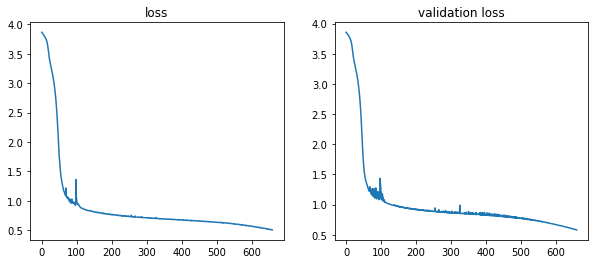

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

print("Training history")
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(sequence_test.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(sequence_test.history.history['val_loss'])
ax2.set_title('validation loss')